使用评论文本将影评分为积极（positive）或消极（nagetive）两类
- https://tensorflow.google.cn/tutorials/keras/text_classification
- https://blog.csdn.net/dgvv4/article/details/124361107

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

### 获取数据集

使用keras内置的imdb影评数据集。考虑到单词量很大，为了简化计算复杂程度，只对10000个常用单词进行逐个编码，对其他生僻的单词使用统一的符号表示，生僻词对训练结果的影响也不是很大。

In [6]:
# 导入电影评价数据
# 只对常见单词编码，数量1w个，生僻单词用统一的符号表示
total_words = 10000
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=total_words)

### 探索数据

该数据集是经过预处理的：每个样本都是一个表示影评中词汇的整数数组。每个标签都是一个值为 0 或 1 的整数值，其中 0 代表消极评论，1 代表积极评论。

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
# 评论文本被转换为整数值，其中每个整数代表词典中的一个单词。首条评论是这样的
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# 电影评论可能具有不同的长度。以下代码显示了第一条和第二条评论的中单词数量。
len(train_data[0]), len(train_data[1])

(218, 189)

将整数转换回单词

In [7]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1641221/1641221 [==============================] - 0s 0us/step


In [8]:
# 首条评论的文本
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 准备数据

由于神经网络的输入必须是统一的长度,因此设置影评长度统一为256，即少于256个单词的影评通过0填充到长度256，而超过256个单词的句子只取前256个单词。

In [10]:
# 设置每个句子的长度, 统一输入网络模型的句子长度
# 处理后的shape为[b,256]，有b个句子每个句子有80个单词
max_review_len = 256
# 将长度小于256的句子填充，将长度大于256的句子截断
train_data = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_review_len)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_review_len)

len(train_data[0]), len(train_data[1]) #(256, 256)

(256, 256)

### 构建模型

In [11]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
1. 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
2. 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
3. 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
4. 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

In [12]:
# 由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 创建一个验证集

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 训练模型

以 512 个样本的 mini-batch 大小迭代 20 个 epoch 来训练模型

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5043 - val_loss: 0.6907 - val_accuracy: 0.5369
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6870 - accuracy: 0.6474 - val_loss: 0.6832 - val_accuracy: 0.6653
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.6755 - accuracy: 0.6747 - val_loss: 0.6688 - val_accuracy: 0.7361
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.6543 - accuracy: 0.7527 - val_loss: 0.6442 - val_accuracy: 0.7572
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6227 - accuracy: 0.7798 - val_loss: 0.6110 - val_accuracy: 0.7771
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.5814 - accuracy: 0.8037 - val_loss: 0.5703 - val_accuracy: 0.7935
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.5334 - accuracy: 0.8249 - val_loss: 0.5240 - val_accuracy: 0.8192
Epoch 8/20
30

### 评估模型

In [15]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 0s - loss: 0.3081 - accuracy: 0.8743 - 464ms/epoch - 594us/step
[0.3081074059009552, 0.8743199706077576]


绘制训练曲线

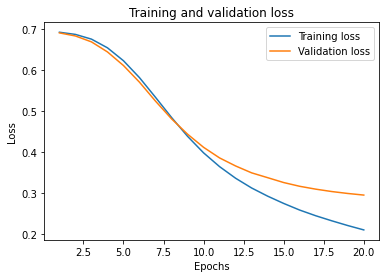

In [18]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

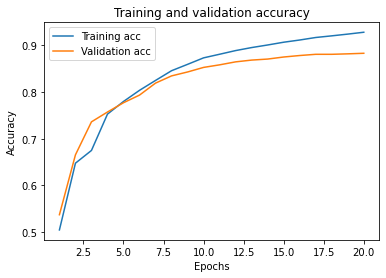

In [19]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()